## Підсумкова лабораторна робота з дисципліни «Моделі інтелектуальних систем»

Датасет: Data Collected with Package Delivery Quadcopter Drone

https://kilthub.cmu.edu/articles/dataset/Data_Collected_with_Package_Delivery_Quadcopter_Drone/12683453

In [82]:
# ── 1. Імпорт бібліотек ─────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

import keras_tuner as kt

%matplotlib inline  

In [ ]:
# ── 2. Завантаження та попередня обробка ────────────────────────────────────
df = pd.read_csv('flights.csv', low_memory=False)           # детальні часові ряди
df_params = pd.read_csv('parameters.csv')                   # підсумкові дані по рейсу

print(df.shape)  # розмір таблиці
print(df.columns)  # назви колонок

# приводимо altitude до float; невдалий парсинг перетвориться на NaN
df['altitude'] = pd.to_numeric(df['altitude'], errors='coerce')

# скільки NaN з’явилося:
print(df['altitude'].isna().sum(), "missing altitude values")


(257896, 28)
Index(['flight', 'time', 'wind_speed', 'wind_angle', 'battery_voltage',
       'battery_current', 'position_x', 'position_y', 'position_z',
       'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w',
       'velocity_x', 'velocity_y', 'velocity_z', 'angular_x', 'angular_y',
       'angular_z', 'linear_acceleration_x', 'linear_acceleration_y',
       'linear_acceleration_z', 'speed', 'payload', 'altitude', 'date',
       'time_day', 'route'],
      dtype='object')
2185 missing altitude values


In [84]:
# конвертуємо дату й час у єдиний datetime-стовпець
df['time_day'] = df['time_day'].astype(str)

base_ts = pd.to_datetime(df['date'] + ' ' + df['time_day'],
                         format='%Y-%m-%d %H:%M')

df['timestamp'] = base_ts + pd.to_timedelta(df['time'], unit='s')

df.drop(columns=['date', 'time_day', 'time'], inplace=True)

# обчислимо миттєву потужність (в ватах)
df['power'] = df['battery_voltage'] * df['battery_current']

print(df.head())
print(df.dtypes)

   flight  wind_speed  wind_angle  battery_voltage  battery_current  \
0       1         0.1        12.0        24.222174         0.087470   
1       1         0.1         3.0        24.227180         0.095421   
2       1         0.1       352.0        24.225929         0.095421   
3       1         0.1       354.0        24.224678         0.095421   
4       1         0.1       359.0        24.210905         0.079518   

   position_x  position_y  position_z  orientation_x  orientation_y  ...  \
0  -79.782396   40.458047  269.332402       0.001772       0.005610  ...   
1  -79.782396   40.458047  269.332056       0.001768       0.005607  ...   
2  -79.782396   40.458047  269.333081       0.001768       0.005607  ...   
3  -79.782396   40.458047  269.334648       0.001775       0.005614  ...   
4  -79.782396   40.458047  269.336178       0.001775       0.005614  ...   

   angular_z  linear_acceleration_x  linear_acceleration_y  \
0   0.006815               0.004258              -0.12

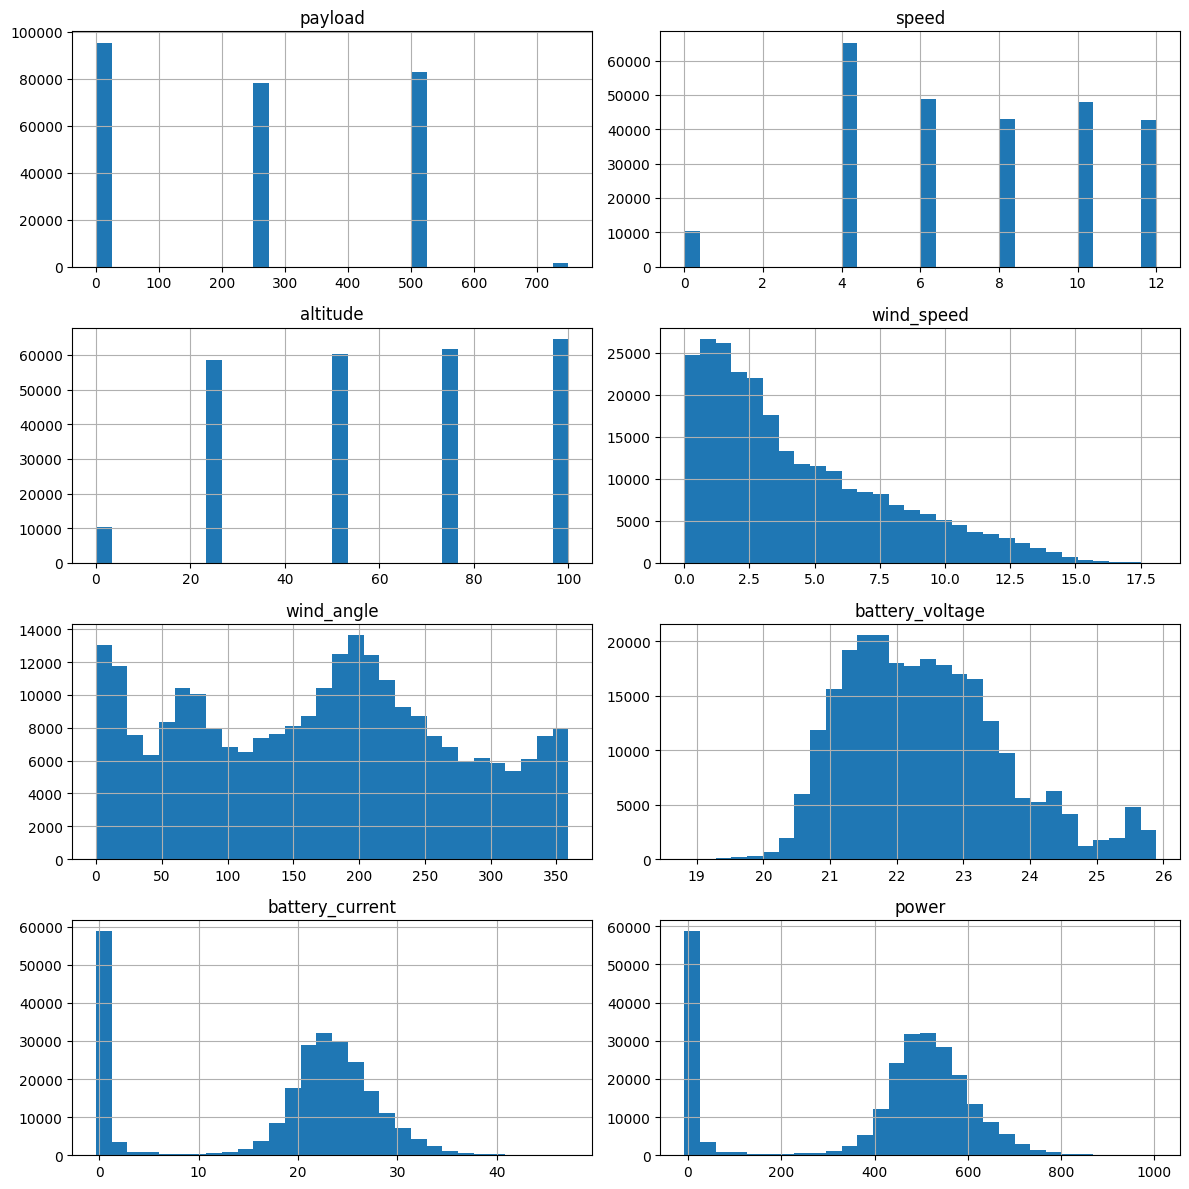

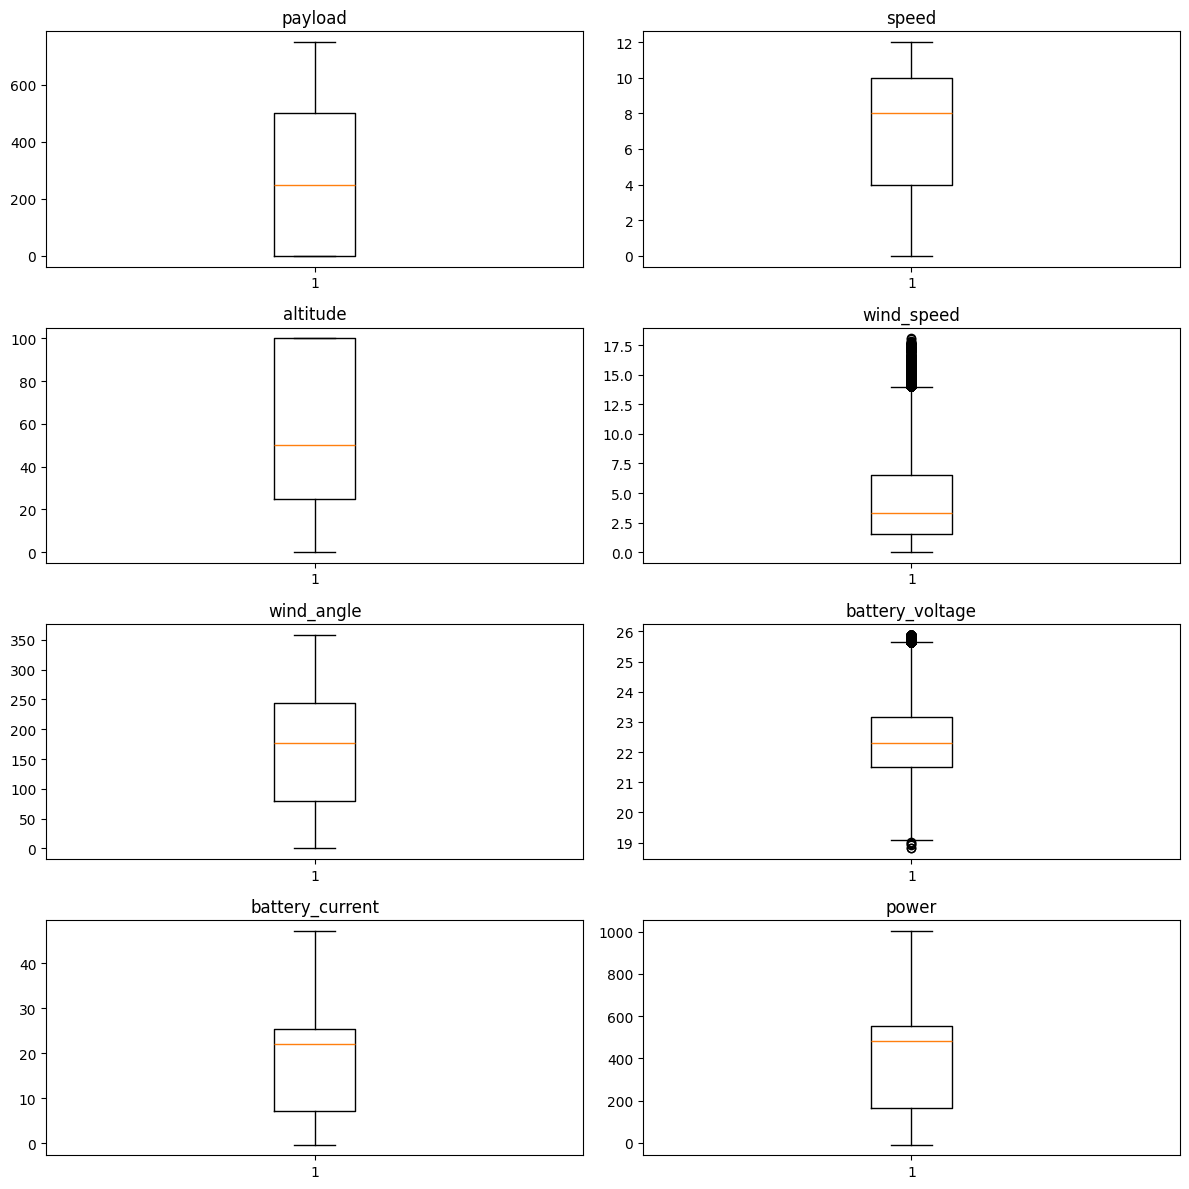

In [85]:
# ── 3. Гістограми та box ─────────────────────────────────────────────

# підрахуємо напрям і прискорення ───────────────────────────────

# Heading (курс) — із вектору швидкості (velocity_x, velocity_y)
# арктангенс повертає курс в радіанах; переводимо в градуси 0–360°
df['heading_rad'] = np.arctan2(df['velocity_y'], df['velocity_x'])
df['heading_deg'] = (np.degrees(df['heading_rad']) + 360) % 360

# Magnitude of linear acceleration — із лінійних компонентів
df['accel_mag'] = np.sqrt(
    df['linear_acceleration_x']**2 +
    df['linear_acceleration_y']**2 +
    df['linear_acceleration_z']**2
)

# Horizontal accel & vertical accel окремо 
df['accel_horiz'] = np.sqrt(df['linear_acceleration_x']**2 + df['linear_acceleration_y']**2)
df['accel_vert'] = df['linear_acceleration_z']

# видалимо зайві стовпці
drop_cols = ['velocity_x', 'velocity_y', 'linear_acceleration_x',
             'linear_acceleration_y', 'linear_acceleration_z', 'heading_rad']

df.drop(columns=drop_cols, inplace=True)

numeric = ['payload', 'speed', 'altitude', 'wind_speed', 'wind_angle',
           'battery_voltage', 'battery_current', 'power', 
           'heading_deg', 'accel_mag', 'accel_horiz', 'accel_vert']

# Гістограми
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()
for ax, col in zip(axes, numeric):
    df[col].hist(bins=30, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# Box
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()
for ax, col in zip(axes, numeric):
    ax.boxplot(df[col].dropna())
    ax.set_title(col)
plt.tight_layout()
plt.show()

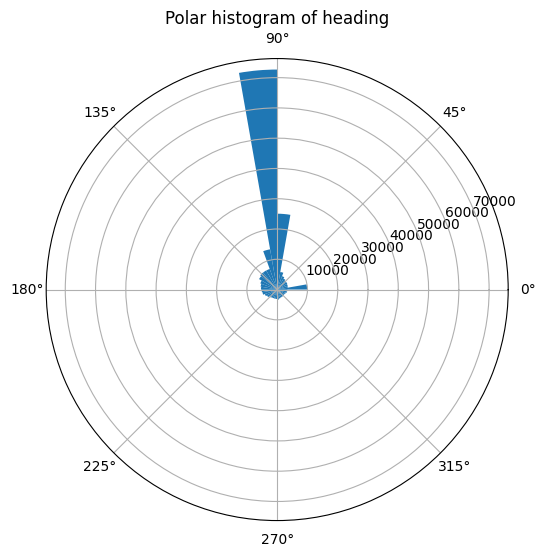

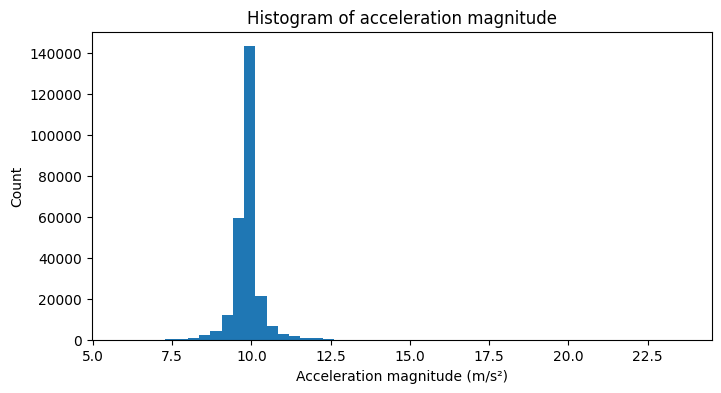

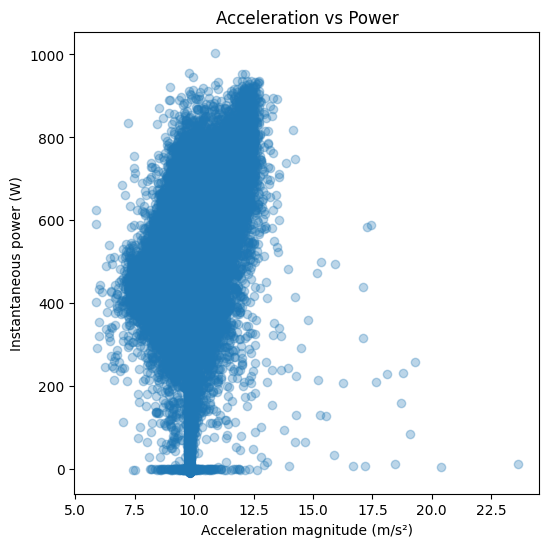

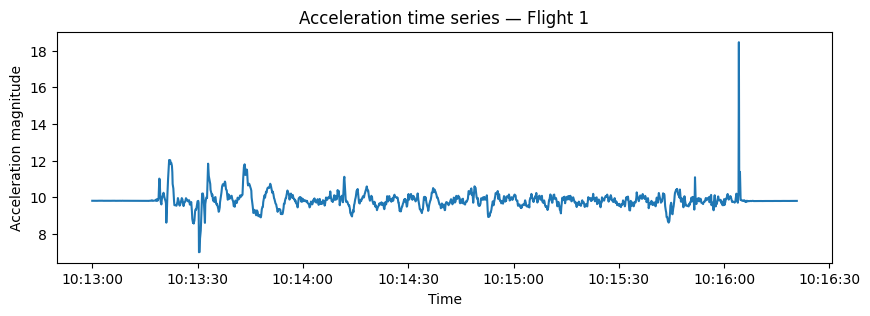

In [86]:
# ── 3.1 Візуалізації напрямку і прискорення ────────────────────────────────

# Polar‑гістограма heading‑ів
plt.figure(figsize=(6,6))
# Переводимо в радіани для побудови
angles = np.deg2rad(df['heading_deg'].dropna())
plt.subplot(projection='polar')
plt.hist(angles, bins=36)
plt.title('Polar histogram of heading')
plt.show()

# Розподіл прискорення
plt.figure(figsize=(8,4))
plt.hist(df['accel_mag'], bins=50)
plt.xlabel('Acceleration magnitude (m/s²)')
plt.ylabel('Count')
plt.title('Histogram of acceleration magnitude')
plt.show()

# 1Scatter: accel_mag vs power
plt.figure(figsize=(6,6))
plt.scatter(df['accel_mag'], df['power'], alpha=0.3)
plt.xlabel('Acceleration magnitude (m/s²)')
plt.ylabel('Instantaneous power (W)')
plt.title('Acceleration vs Power')
plt.show()

# Часовий ряд прискорення для прикладу рейсу
sample_ids = df['flight'].unique()[:3]
fid = sample_ids[0]
tmp = df[df['flight']==fid]
plt.figure(figsize=(10,3))
plt.plot(tmp['timestamp'], tmp['accel_mag'])
plt.xlabel('Time')
plt.ylabel('Acceleration magnitude')
plt.title(f'Acceleration time series — Flight {fid}')
plt.show()

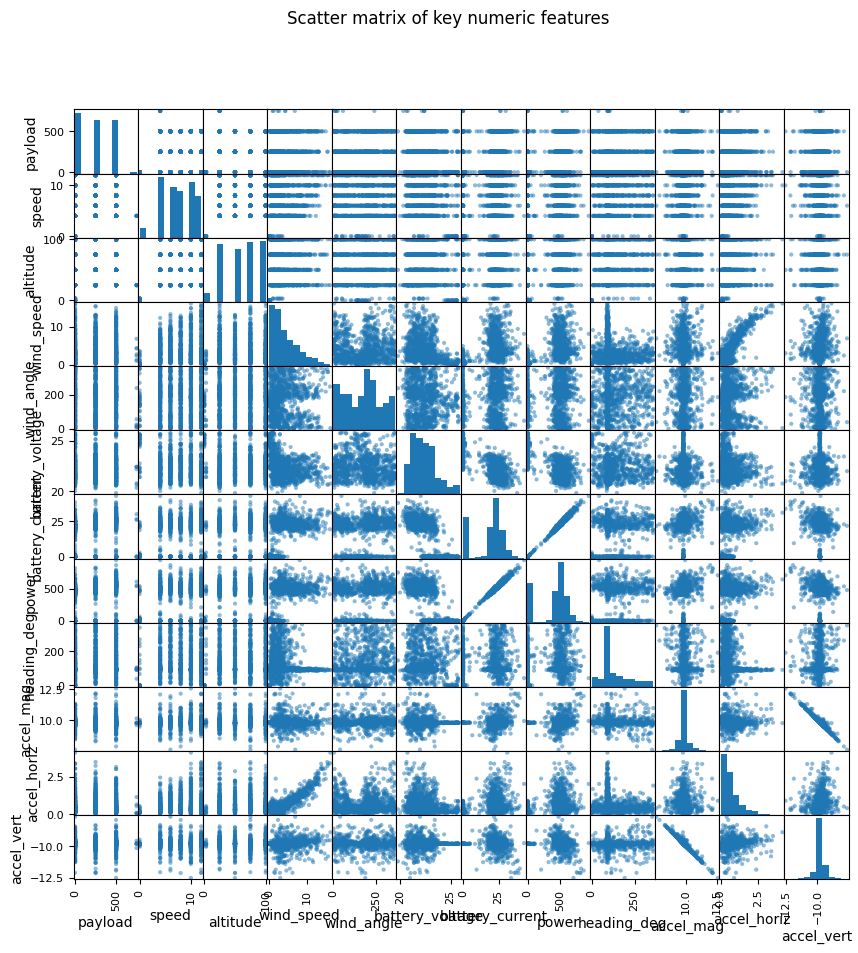

In [87]:
# ── 4. Матриця розсіяння ─────────────────────────────────────────────────────
sample = df[numeric].sample(n=min(1000, len(df)), random_state=1)
scatter_matrix(sample, figsize=(10, 10), diagonal='hist')
plt.suptitle('Scatter matrix of key numeric features')
plt.show()


Розмір оригіналу: 257896, після видалення викидів: 167500


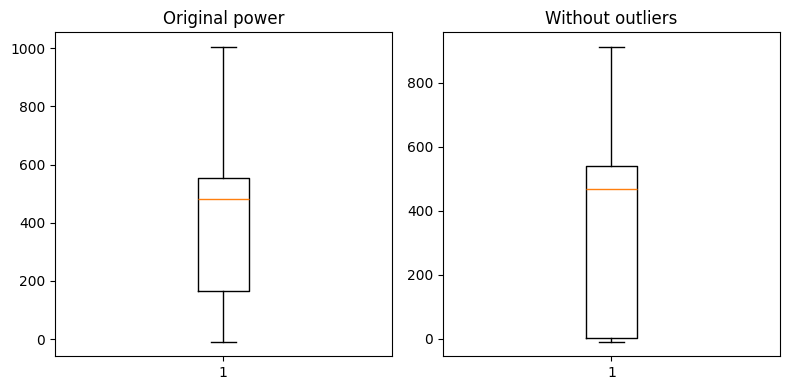

In [88]:
# ── 5. Викиди: IQR‑фільтрація ────────────────────────────────────────────────
df_no = df.copy()
for col in numeric:
    Q1 = df_no[col].quantile(0.25)
    Q3 = df_no[col].quantile(0.75)
    IQR = Q3 - Q1
    low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df_no = df_no[(df_no[col] >= low) & (df_no[col] <= high)]

print(f'Розмір оригіналу: {len(df)}, після видалення викидів: {len(df_no)}')

# Порівняння box‑плотів до/після (для power)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].boxplot(df['power'].dropna())
ax[0].set_title('Original power')
ax[1].boxplot(df_no['power'].dropna())
ax[1].set_title('Without outliers')
plt.tight_layout()
plt.show()

In [89]:
# ── 6. Нормалізація ознак ───────────────────────────────────────────────────
scaler = StandardScaler()
df_norm = df_no.copy()
df_norm[numeric] = scaler.fit_transform(df_norm[numeric])

# Переглянемо перші 5 рядків нормалізованих даних
print(df_norm[numeric].head())

   payload     speed  altitude  wind_speed  wind_angle  battery_voltage  \
0 -1.11381 -0.907679 -1.124678   -1.186262   -1.581092         1.392994   
1 -1.11381 -0.907679 -1.124678   -1.186262   -1.672745         1.397191   
2 -1.11381 -0.907679 -1.124678   -1.186262    1.881353         1.396143   
3 -1.11381 -0.907679 -1.124678   -1.186262    1.901721         1.395094   
4 -1.11381 -0.907679 -1.124678   -1.186262    1.952639         1.383548   

   battery_current     power  heading_deg  accel_mag  accel_horiz  accel_vert  
0        -1.376312 -1.381219     1.245396  -0.021403    -1.001674   -0.186141  
1        -1.375617 -1.380448     0.981405  -0.027768    -1.010472   -0.180140  
2        -1.375617 -1.380448     0.984928  -0.034204    -0.983405   -0.172472  
3        -1.375617 -1.380449     1.399659  -0.028462    -0.984153   -0.178266  
4        -1.377007 -1.381992     1.334502  -0.013494    -1.002360   -0.194102  


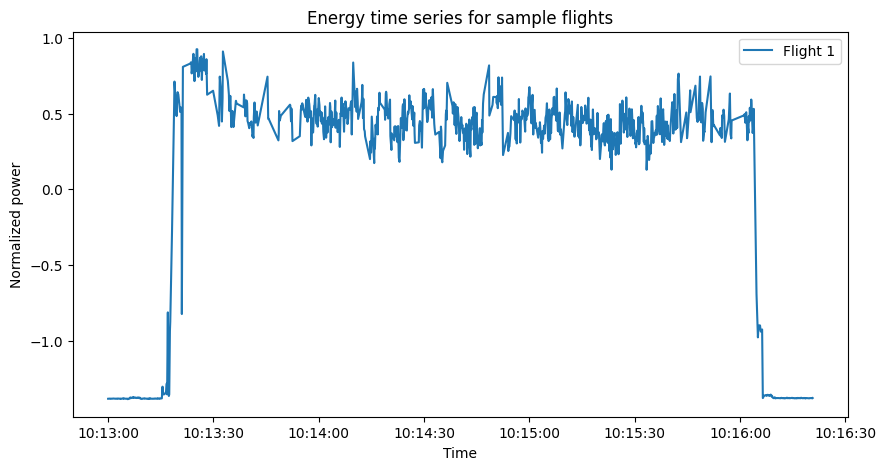

In [122]:
# ── 7. Часові ряди енергоспоживання ────────────────────────────────────
# Виберемо 3 довільних рейси
sample_ids = df_norm['flight'].unique()[:1]
plt.figure(figsize=(10, 5))
for fid in sample_ids:
    tmp = df_norm[df_norm['flight'] == fid]
    plt.plot(tmp['timestamp'], tmp['power'], label=f'Flight {fid}')
plt.xlabel('Time')
plt.ylabel('Normalized power')
plt.title('Energy time series for sample flights')
plt.legend()
plt.show()

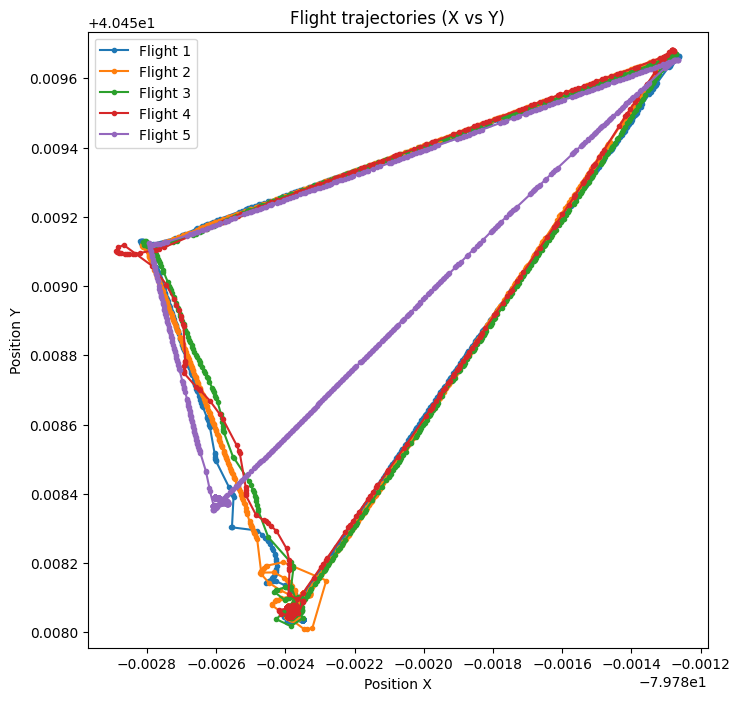

In [121]:
# ── 8. Траєкторії польотів ─────────────────────────────────────────────────
plt.figure(figsize=(8, 8))
for fid in sample_ids:
    tmp = df_norm[df_norm['flight'] == fid]
    plt.plot(tmp['position_x'], tmp['position_y'], marker='.', linestyle='-', label=f'Flight {fid}')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('Flight trajectories (X vs Y)')
plt.legend()
plt.axis('equal')
plt.show()

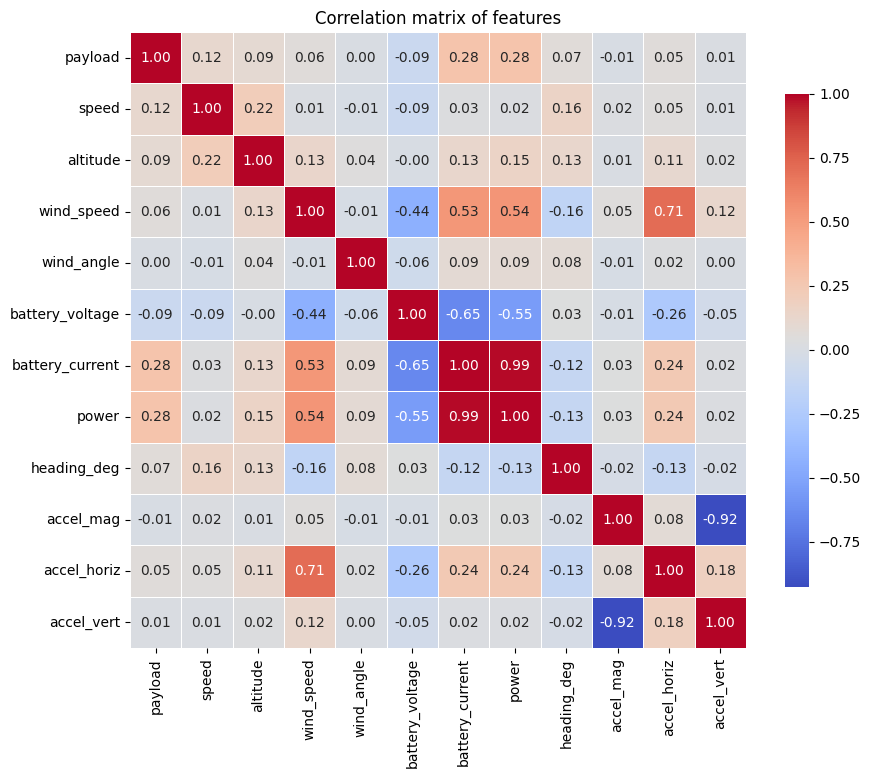

In [92]:
# ── Кореляційний аналіз ─────────────────────────────────────────────────────
import seaborn as sns

df_corr = df_norm[numeric] 

# Обчислення кореляційної матриці
corr_matrix = df_corr.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'shrink': .8}, linewidths=.5)
plt.title('Correlation matrix of features')
plt.show()

In [93]:
corr_unstacked = corr_matrix.abs().unstack()
# відсортувати та відкинути (feature, feature) пари
corr_pairs = (corr_unstacked
              .sort_values(kind="quicksort", ascending=False)
              .reset_index(name='abs_corr'))
# залишимо лише перший раз кожну пару
corr_pairs = corr_pairs[corr_pairs['level_0'] != corr_pairs['level_1']]
corr_pairs = corr_pairs.drop_duplicates(subset=['abs_corr'])
print("Top correlated pairs:")
print(corr_pairs.head(10))

Top correlated pairs:
            level_0          level_1  abs_corr
12  battery_current            power  0.988429
14        accel_mag       accel_vert  0.924977
16       wind_speed      accel_horiz  0.709148
18  battery_current  battery_voltage  0.647692
20            power  battery_voltage  0.554450
22       wind_speed            power  0.536105
24       wind_speed  battery_current  0.531577
26  battery_voltage       wind_speed  0.441018
28            power          payload  0.284008
30          payload  battery_current  0.278734


Серед зовнішніх ознак найсильніший кореляційний сигнал із power дає

wind_speed (ρ≈0.53)

payload (ρ≈0.28)

altitude (ρ≈0.15)
– трохи слабкіше впливають speed, heading_deg, accel_*.

Мультиколінеарності між цими зовнішніми фічами немає (вони корелюють помірно до 0.3–0.5), тож можна брати відразу кілька змінних у модель.


Оскільки зв’язки помірно — але не лінійно — корелюють і є і взаємодії (напр. вітер × payload), краще всього підійде нейронна мережа‑регресор (DNN) із декількома шарами. Вона зможе вловити нелінійні ефекти й взаємодії.

In [94]:
# 1) Вибираємо фічі (зовнішні, без battery_current/voltage) та цільову
features = df_norm[[
    'payload',
    'speed',
    'altitude',
    'wind_speed',
    'heading_deg',
    'accel_mag',
    'accel_horiz',
    'accel_vert'
]]
target = df_norm['power']

# 2) Спочатку відокремимо 30% для валідації+тесту
X_train, X_temp, y_train, y_temp = train_test_split(
    features, target,
    test_size=0.30,
    random_state=42
)

# 3) Поділимо «тимчасову» на 50/50 → 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42
)

# 4) Перевіримо розміри
print(f"Train:    {X_train.shape[0]} прикладів")
print(f"Validation: {X_val.shape[0]} прикладів")
print(f"Test:       {X_test.shape[0]} прикладів")

Train:    117250 прикладів
Validation: 25125 прикладів
Test:       25125 прикладів


In [95]:
# ── ВІД ПІДГОТОВКИ ДО ТЮНІНГУ ───────────────────────────────────

# створення моделі
def build_model(hp: kt.HyperParameters):
    model = Sequential()
    # Перший шар
    model.add(Dense(
        units=hp.Int('units1', min_value=32, max_value=128, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    # Dropout
    model.add(Dropout(rate=hp.Choice('dropout1', [0.0, 0.2, 0.5])))
    # Друга шар
    model.add(Dense(
        units=hp.Int('units2', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    # Вихід
    model.add(Dense(1))
    # Компіляція
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='mse',
        metrics=['mae']
    )
    return model

In [96]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',       # мінімізуємо MAE на валідації
    max_trials=10,             # скільки комбінацій спробувати
    executions_per_trial=1,    # скільки разів тренувати кожну комбінацію
    directory='tuner_dir',
    project_name='energy_model'
)

# ── 5. ПОШУК ГІПЕРПАРАМЕТРІВ ─────────────────────────────────────────────────
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


tuner.results_summary()

Trial 10 Complete [00h 05m 27s]
val_mae: 0.1862524300813675

Best val_mae So Far: 0.18208442628383636
Total elapsed time: 01h 02m 44s
Results summary
Results in tuner_dir/energy_model
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 07 summary
Hyperparameters:
units1: 32
dropout1: 0.2
units2: 32
learning_rate: 0.001
Score: 0.18208442628383636

Trial 05 summary
Hyperparameters:
units1: 96
dropout1: 0.0
units2: 64
learning_rate: 0.0001
Score: 0.1845092922449112

Trial 04 summary
Hyperparameters:
units1: 32
dropout1: 0.0
units2: 32
learning_rate: 0.001
Score: 0.18525725603103638

Trial 06 summary
Hyperparameters:
units1: 96
dropout1: 0.5
units2: 32
learning_rate: 0.0001
Score: 0.185878187417984

Trial 09 summary
Hyperparameters:
units1: 128
dropout1: 0.0
units2: 32
learning_rate: 0.0001
Score: 0.1862524300813675

Trial 02 summary
Hyperparameters:
units1: 32
dropout1: 0.2
units2: 64
learning_rate: 0.001
Score: 0.18802085518836975

Trial 00 summary
Hyperparameters:
u

In [101]:
def extract_last_numeric(hist):
    flat = []
    for entry in hist:
        if isinstance(entry, (list, tuple)):
            # розгортаємо вкладений список
            for sub in entry:
                flat.append(sub.value if hasattr(sub, 'value') else sub)
        else:
            flat.append(entry.value if hasattr(entry, 'value') else entry)
    return flat[-1]

In [119]:
# Збираємо історії всіх trial
trials = tuner.oracle.get_best_trials(num_trials=10)  # всі спроби  
records = []
for trial in tuner.oracle.trials.values():
    train_hist = trial.metrics.get_history('mae')
    val_hist   = trial.metrics.get_history('val_mae')
    
    train_mae = extract_last_numeric(train_hist)
    val_mae   = extract_last_numeric(val_hist)
    
    hps = trial.hyperparameters.values
    records.append({
        **hps,
        'train_mae': train_mae[0],
        'val_mae':   val_mae[0],
        'gap':       val_mae[0] - train_mae[0]
    })


df_trials = pd.DataFrame(records)

# Три найгірші за train_mae → підозра на underfitting
print("UNDERFITTING candidates:")
print(df_trials.nsmallest(3, 'train_mae')[[
    'units1','dropout1','units2','learning_rate','train_mae','val_mae'
]])

# Три найбільші за gap → підозра на overfitting
print("\nOVERFITTING candidates:")
print(df_trials.nlargest(3, 'gap')[[
    'units1','dropout1','units2','learning_rate','train_mae','val_mae','gap'
]])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nSelected parameters:")
print("units1        =", best_hps.get('units1'))
print("dropout1      =", best_hps.get('dropout1'))
print("units2        =", best_hps.get('units2'))
print("learning_rate =", best_hps.get('learning_rate'))

UNDERFITTING candidates:
   units1  dropout1  units2  learning_rate  train_mae   val_mae
5      96       0.0      64         0.0001   0.184879  0.184509
9     128       0.0      32         0.0001   0.186868  0.186252
3      96       0.0      32         0.0001   0.188604  0.189305

OVERFITTING candidates:
   units1  dropout1  units2  learning_rate  train_mae   val_mae       gap
3      96       0.0      32         0.0001   0.188604  0.189305  0.000700
5      96       0.0      64         0.0001   0.184879  0.184509 -0.000370
9     128       0.0      32         0.0001   0.186868  0.186252 -0.000616

Selected parameters:
units1        = 32
dropout1      = 0.2
units2        = 32
learning_rate = 0.001


атрибут .history не зберігається, найпростіший шлях — дістати накращі гіперпараметри й заново натренувати модель «вручну», щоб отримати об'єкт

Epoch 1/50
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3631 - mae: 0.4433 - val_loss: 0.1494 - val_mae: 0.2487
Epoch 2/50
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1475 - mae: 0.2354 - val_loss: 0.1298 - val_mae: 0.2058
Epoch 3/50
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1369 - mae: 0.2210 - val_loss: 0.1237 - val_mae: 0.1964
Epoch 4/50
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1329 - mae: 0.2179 - val_loss: 0.1243 - val_mae: 0.1988
Epoch 5/50
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1302 - mae: 0.2125 - val_loss: 0.1203 - val_mae: 0.2000
Epoch 6/50
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1267 - mae: 0.2092 - val_loss: 0.1207 - val_mae: 0.1899
Epoch 7/50
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1268 - mae: 0.2082 - val_loss: 0.1210 - val_mae: 0.1999
Epoch 8/50
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1239 - mae: 0.2057 - val_loss: 0.1212 - val_mae: 0.2030
Epoch 9/50
3665/3665 ━━━━━━━━━━━━━━━━━━━

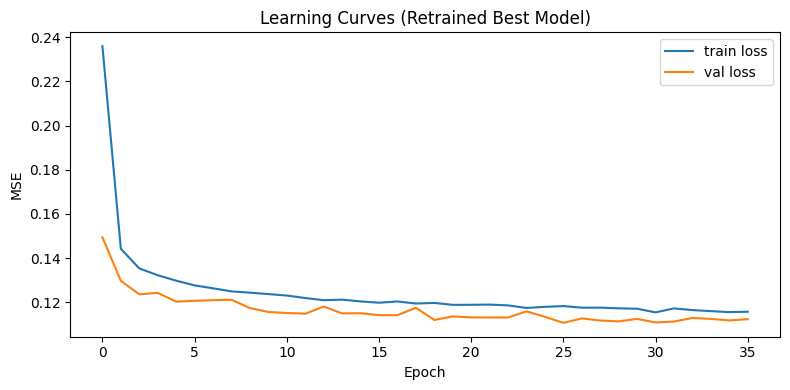

In [114]:
# ──  КРИВІ НАВЧАННЯ ДЛЯ НАЙКРАЩОЇ МОДЕЛІ ───────────────────────────────────

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

def build_best_model(hp):
    # конструкція точно така ж, як у build_model
    model = Sequential()
    model.add(Dense(
        units=hp.get('units1'),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(Dropout(rate=hp.get('dropout1')))
    model.add(Dense(
        units=hp.get('units2'),
        activation='relu'
    ))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.get('learning_rate')),
        loss='mse',
        metrics=['mae']
    )
    return model

best_model = build_best_model(best_hps)

# Додаємо EarlyStopping, щоб автоматично зупинити навчання на оптимальній епосі
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Навчаємо з валідацією і ловимо history
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],  label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Learning Curves (Retrained Best Model)')
plt.legend()
plt.tight_layout()
plt.show()

786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step
Mean Squared Error (MSE):              0.1091
Root Mean Squared Error (RMSE):        0.3304
Mean Absolute Error (MAE):             0.1836
Mean Absolute Percentage Error (MAPE): 71.30%
R-squared (R²):                        0.8910


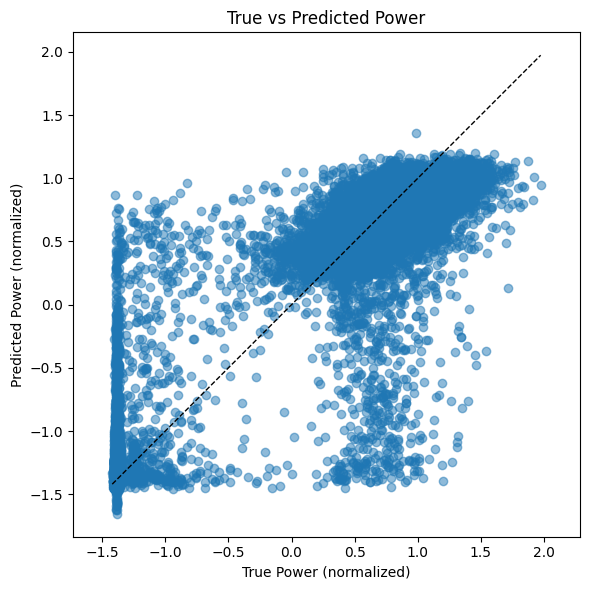

In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Передбачення на тестовій вибірці
y_pred = best_model.predict(X_test).flatten()

# Обчислення ключових метрик
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE):              {mse:.4f}")
print(f"Root Mean Squared Error (RMSE):        {rmse:.4f}")
print(f"Mean Absolute Error (MAE):             {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")
print(f"R-squared (R²):                        {r2:.4f}")

# Візуалізація 1: True vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', linewidth=1)
plt.xlabel("True Power (normalized)")
plt.ylabel("Predicted Power (normalized)")
plt.title("True vs Predicted Power")
plt.axis('equal')
plt.tight_layout()
plt.show()



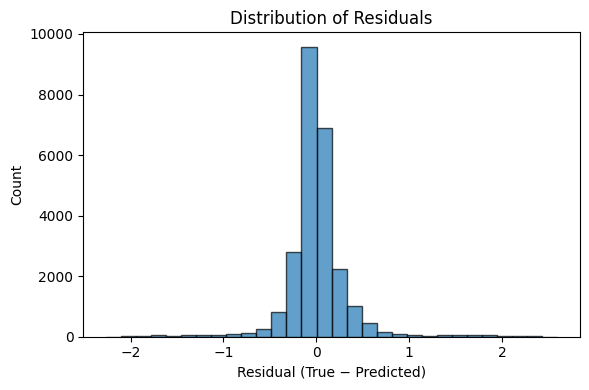

In [116]:
# Візуалізація 2: Розподіл залишків
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residual (True − Predicted)")
plt.ylabel("Count")
plt.title("Distribution of Residuals")
plt.tight_layout()
plt.show()



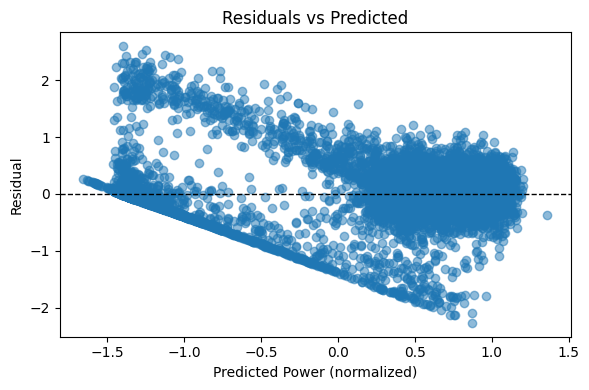

In [117]:
# Додаткова візуалізація: Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel("Predicted Power (normalized)")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()